# Geospatial Data Visualizations of Event Bookings 2018-2023

In [1]:
import matplotlib.pyplot as plt
import psycopg2
import pandas as pd
import timeit
import string
from sqlalchemy import create_engine
from shapely.geometry import Point
import pysal
import splot
import folium
import seaborn as sns
from folium.plugins import HeatMap, HeatMapWithTime
from datetime import datetime, timedelta
import plotly.express as px


In [2]:
# Connect to your PostgreSQL local

dbname = 'postgres'
user = 'postgres'
password = ''
host = 'localhost'
port = '5432'

conn1 = psycopg2.connect(dbname = dbname, user = user, password = password, host = host, port = port)
cur = conn1.cursor()

# Heatmap of all Bookings

The first visualization is a heatmap of all my 2601 bookings in North and South America from 2018-2023. In order to display the frequency and magnitude of all bookings geographically, a query must be run on the 3NF database in order to display the latitude and longitude of every booking:

In [25]:
query = """
    SELECT
        e.artistid,
        a.artistname,
        e.showdate,
        e.venueid,
        v.venuename,
        v.city,
        v.latitude,
        v.longitude
    FROM
        events AS e
    JOIN
        venues AS v ON e.venueid = v.venueid
    JOIN
        artists AS a ON e.artistid = a.artistid;
"""

In [26]:
heatmapdf = pd.read_sql(query, conn1)
heatmapdf

/var/folders/tn/mpsvt245515f8x1174685bp00000gn/T/ipykernel_4843/1229438859.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,artistid,artistname,showdate,venueid,venuename,city,latitude,longitude
0,27,Marbs,2018-01-01,1532,Monkey Loft,Seattle,47.603832,-122.330062
1,17,Dosem,2018-01-01,1604,Parque Cachagua,Maitencillo,-32.929627,-71.294419
2,7,Ardalan,2018-01-01,1855,The Great Northern,San Francisco,37.779026,-122.419906
3,13,Christian Martin,2018-01-01,1839,The Circus Collective,Denver,39.739236,-104.984862
4,41,Steve Bug,2018-01-01,1855,The Great Northern,San Francisco,37.779026,-122.419906
...,...,...,...,...,...,...,...,...
2596,32,PAN-POT,2023-12-31,1635,Proper,San Diego,32.717420,-117.162773
2597,5,ANNA,2023-12-31,1635,Proper,San Diego,32.717420,-117.162773
2598,10,Booka Shade,2023-12-31,1123,Brooklyn Hangar,Brooklyn,40.652601,-73.949721
2599,22,Julya Karma,2023-12-31,1194,Crania,Cabo San Lucas,22.893888,-109.920060


In [27]:
# Drop columns except 'showdate', 'latitude', and 'longitude'
columns_to_keep = ['latitude', 'longitude']
heatmapdf2 = heatmapdf[columns_to_keep]
heatmapdf2

,latitude,longitude
0,47.603832,-122.330062
1,-32.929627,-71.294419
2,37.779026,-122.419906
3,39.739236,-104.984862
4,37.779026,-122.419906
...,...,...
2596,32.717420,-117.162773
2597,32.717420,-117.162773
2598,40.652601,-73.949721
2599,22.893888,-109.920060


In [28]:
# Create heatmap

# Create a Folium map centered around the mean latitude and longitude
m = folium.Map(location=[heatmapdf2['latitude'].mean(), heatmapdf2['longitude'].mean()], zoom_start=3)

# Create a HeatMap using the latitude, longitude, and frequency (count) for each date
heat_data = [[row['latitude'], row['longitude'], 1] for index, row in heatmapdf.iterrows()]
HeatMap(heat_data, radius=20).add_to(m)

# Save the map to an HTML file
m.save('folium_heatmap.html')

# Open the saved Folium map in your web browser
import webbrowser
webbrowser.open('folium_heatmap.html')

True

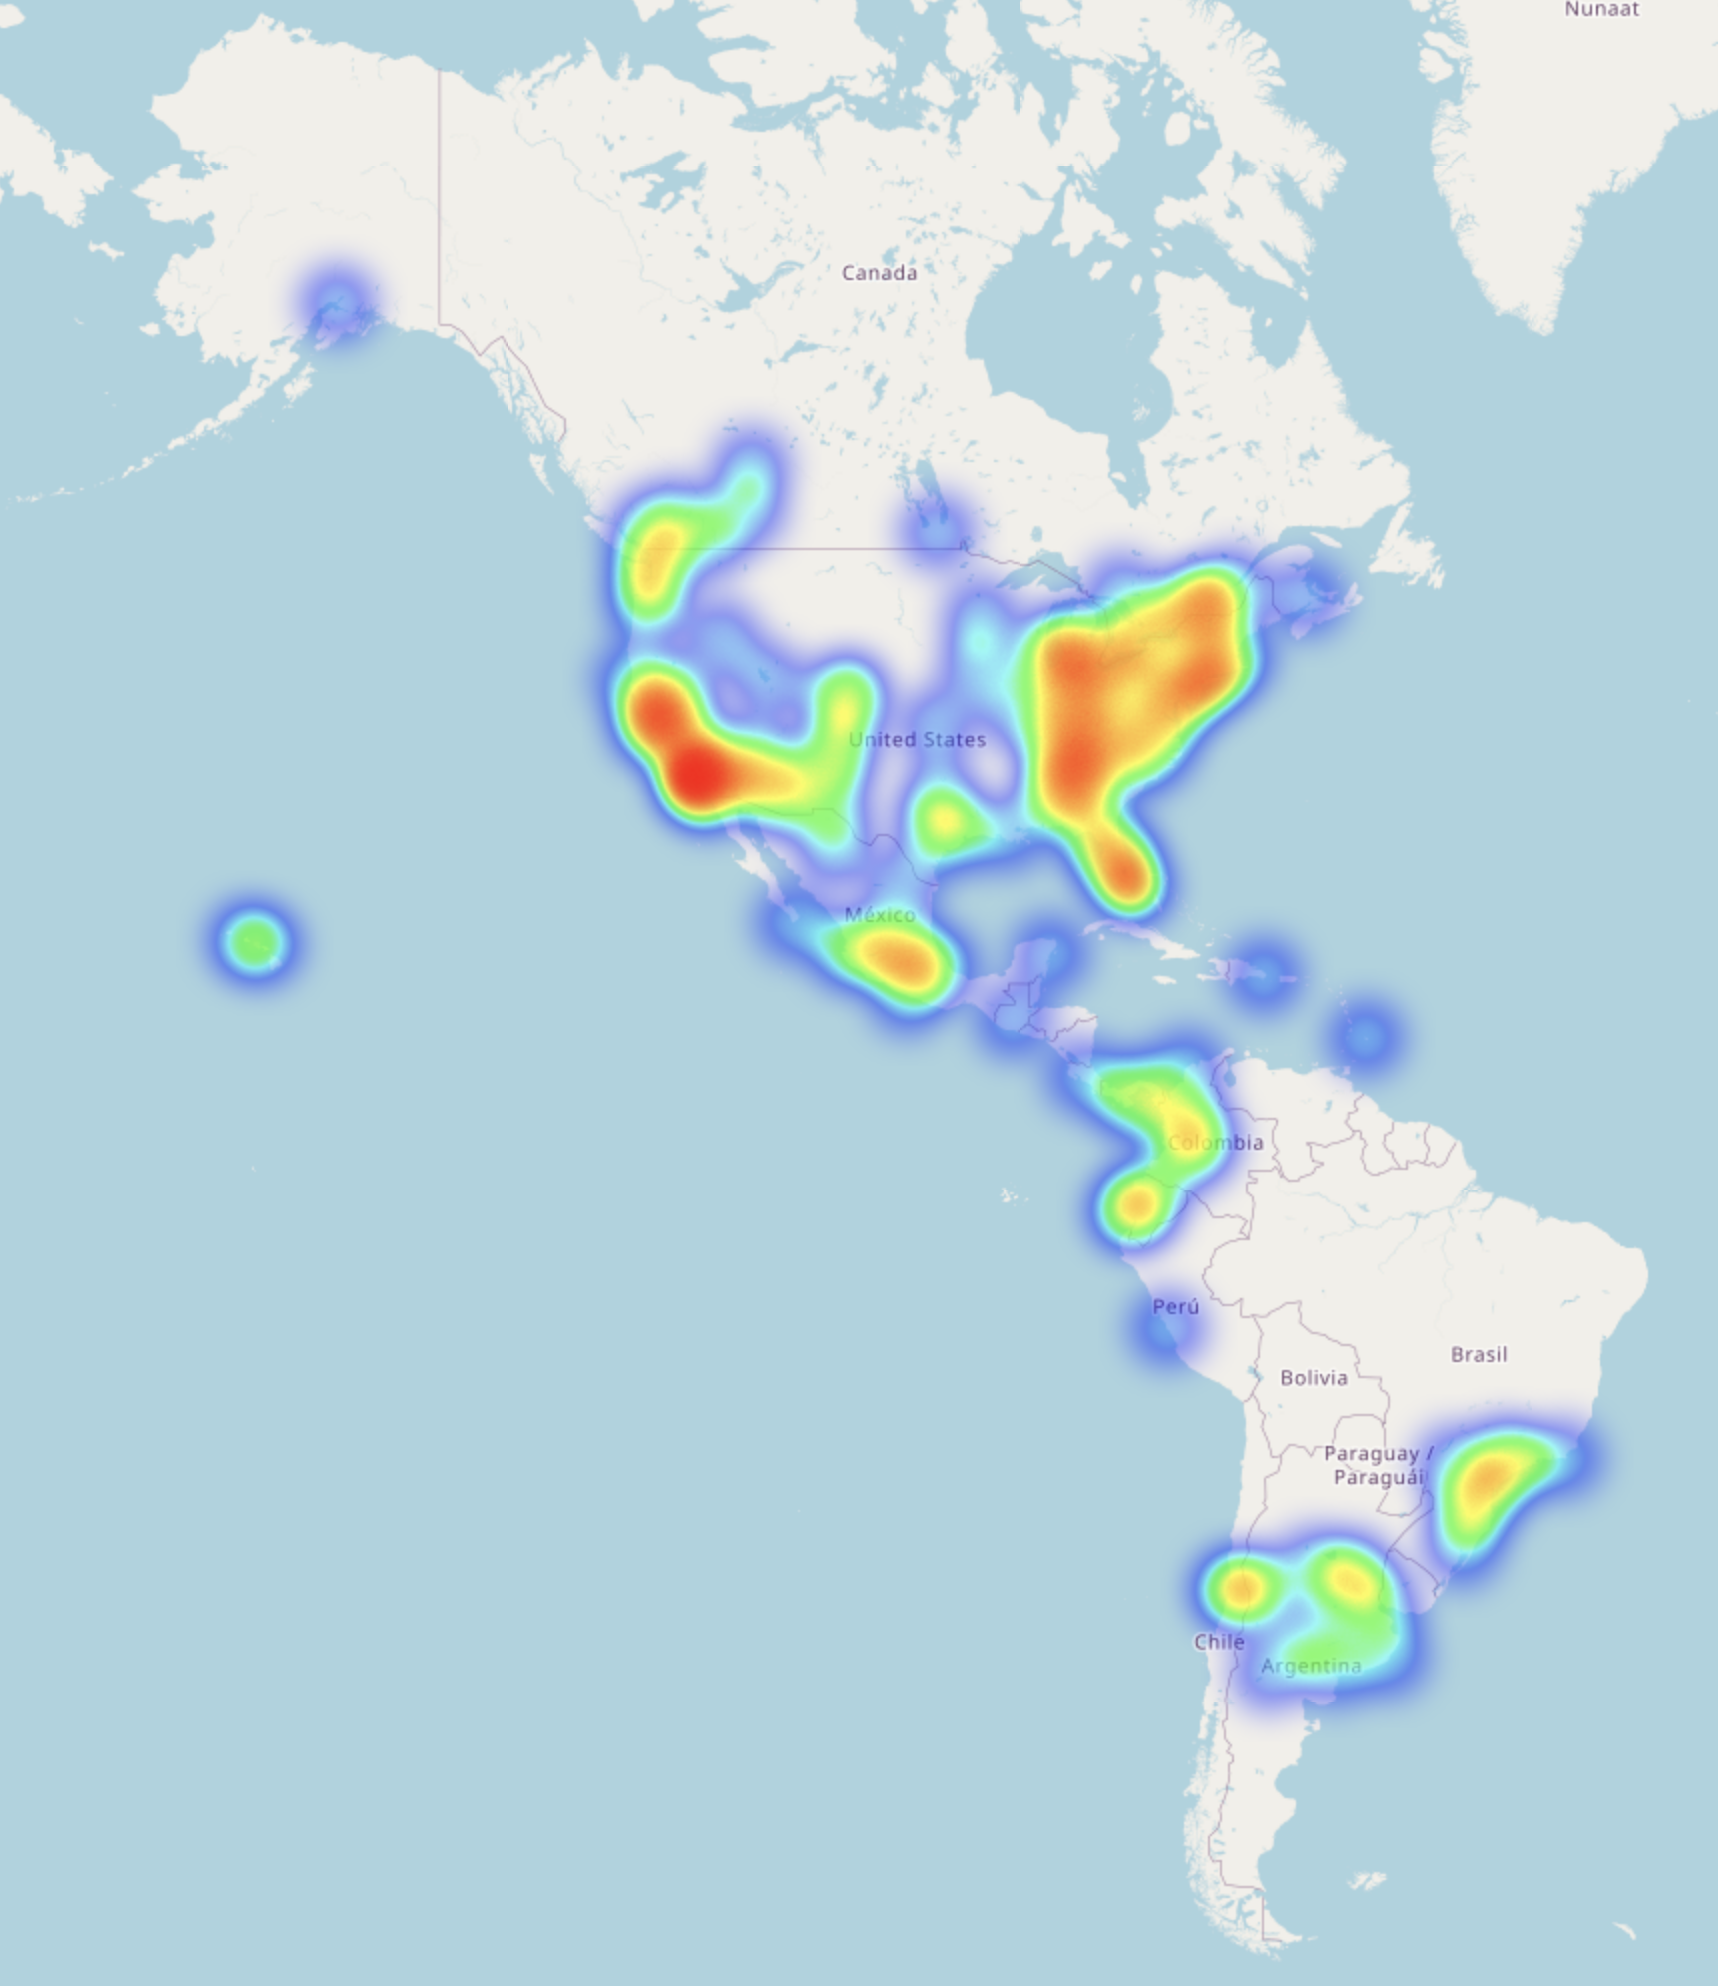

# Create interactive map with mouseover capabilities

### Business query: Locate, identify, and rank by booking frequency, all active Melodic House & Techno promoters within a 600-mile radius of San Francisco, CA. Within the mouseover map visualization, display each promoter's name, booking frequency and distance from SF.

In [29]:
superquery = """
WITH EventPromoterRanking AS (
    SELECT DISTINCT ON (p.promoterid)
        p.promoterid,
        p.promotername,
        COUNT(e.eventid) AS event_count,
        MIN(
            3959 * ACOS(
                COS(RADIANS(v.latitude)) * COS(RADIANS(37.7749)) * COS(RADIANS(v.longitude) - RADIANS(-122.4194))
                + SIN(RADIANS(v.latitude)) * SIN(RADIANS(37.7749))
            )
        ) AS distance_from_sf,
        FIRST_VALUE(v.latitude) OVER (PARTITION BY p.promoterid ORDER BY COUNT(e.eventid) DESC) AS most_frequent_latitude,
        FIRST_VALUE(v.longitude) OVER (PARTITION BY p.promoterid ORDER BY COUNT(e.eventid) DESC) AS most_frequent_longitude,
        FIRST_VALUE(v.city) OVER (PARTITION BY p.promoterid ORDER BY COUNT(e.eventid) DESC) AS most_frequent_city
    FROM
        promoters p
    JOIN
        events e ON p.promoterid = e.promoterid
    JOIN
        artists a ON e.artistid = a.artistid
    JOIN
        venues v ON e.venueid = v.venueid
    WHERE
        (a.artistgenre1 = 'Melodic House & Techno'
        OR a.artistgenre2 = 'Melodic House & Techno'
        OR a.artistgenre3 = 'Melodic House & Techno')
        AND p.active = true
    GROUP BY
        p.promoterid, p.promotername, v.latitude, v.longitude, v.city
    HAVING
        MIN(
            3959 * ACOS(
                COS(RADIANS(v.latitude)) * COS(RADIANS(37.7749)) * COS(RADIANS(v.longitude) - RADIANS(-122.4194))
                + SIN(RADIANS(v.latitude)) * SIN(RADIANS(37.7749))
            )
        ) <= 600
)

SELECT
    promotername,
    event_count,
    RANK() OVER (ORDER BY event_count DESC) AS ranking,
    distance_from_sf,
    most_frequent_latitude,
    most_frequent_longitude,
    most_frequent_city
FROM
    EventPromoterRanking
ORDER BY
    ranking;
"""

In [30]:
# Execute the query and fetch the result into a DataFrame
df = pd.read_sql(superquery, conn1)
df.head(10)

/var/folders/tn/mpsvt245515f8x1174685bp00000gn/T/ipykernel_4843/970211403.py:2: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,promotername,event_count,ranking,distance_from_sf,most_frequent_latitude,most_frequent_longitude,most_frequent_city
0,Audio,22,1,0.286433,37.779026,-122.419906,San Francisco
1,FNGRS CRSSD,13,2,458.203982,32.717420,-117.162773,San Diego
2,Insomniac,11,3,347.400273,34.053691,-118.242766,Los Angeles
3,Apex Presents,8,4,347.400273,34.053691,-118.242766,Los Angeles
4,Lovelife,7,5,458.203982,32.717420,-117.162773,San Diego
5,Framework,6,6,347.400273,34.053691,-118.242766,Los Angeles
6,Public Works,5,7,0.286433,37.779026,-122.419906,San Francisco
7,Halcyon,5,7,0.286433,37.779026,-122.419906,San Francisco
8,Monarch/The Great Northern,5,7,0.286433,37.779026,-122.419906,San Francisco
9,SET,4,10,0.286433,37.779026,-122.419906,San Francisco


In [31]:
# Modify the dataframe for mapping

columns_to_keep = ['promotername', 'event_count', 'ranking', 'distance_from_sf', 'most_frequent_latitude', 'most_frequent_longitude', 'most_frequent_city']
df = df[columns_to_keep]
df['distance_from_sf'] = df['distance_from_sf'].round(1)
df.head(10)

,promotername,event_count,ranking,distance_from_sf,most_frequent_latitude,most_frequent_longitude,most_frequent_city
0,Audio,22,1,0.3,37.779026,-122.419906,San Francisco
1,FNGRS CRSSD,13,2,458.2,32.717420,-117.162773,San Diego
2,Insomniac,11,3,347.4,34.053691,-118.242766,Los Angeles
3,Apex Presents,8,4,347.4,34.053691,-118.242766,Los Angeles
4,Lovelife,7,5,458.2,32.717420,-117.162773,San Diego
5,Framework,6,6,347.4,34.053691,-118.242766,Los Angeles
6,Public Works,5,7,0.3,37.779026,-122.419906,San Francisco
7,Halcyon,5,7,0.3,37.779026,-122.419906,San Francisco
8,Monarch/The Great Northern,5,7,0.3,37.779026,-122.419906,San Francisco
9,SET,4,10,0.3,37.779026,-122.419906,San Francisco


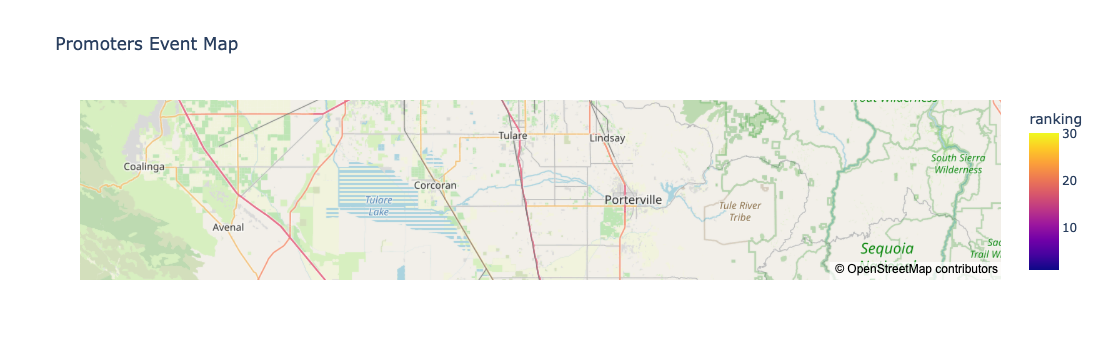

In [32]:
# Create an interactive map using Plotly Express
fig = px.scatter_mapbox(
    df,
    lat='most_frequent_latitude',
    lon='most_frequent_longitude',
    text='promotername',
    hover_data=['event_count', 'distance_from_sf', 'ranking'],
    color='ranking',
    size='event_count',
    size_max=25,
    mapbox_style='open-street-map',
    zoom=8,
    center=dict(lat=df['most_frequent_latitude'].mean(), lon=df['most_frequent_longitude'].mean()),
    title='Promoters Event Map'
)

# Show the interactive map
fig.show()

# Visualizing the relationships between event frequency, time of year and location

In [33]:
# Drop all columns from the heatmapdf except 'showdate', 'latitude', and 'longitude'
columns_to_keep2 = ['showdate', 'latitude', 'longitude']
timeheatmapdf = heatmapdf[columns_to_keep2]
timeheatmapdf

,showdate,latitude,longitude
0,2018-01-01,47.603832,-122.330062
1,2018-01-01,-32.929627,-71.294419
2,2018-01-01,37.779026,-122.419906
3,2018-01-01,39.739236,-104.984862
4,2018-01-01,37.779026,-122.419906
...,...,...,...
2596,2023-12-31,32.717420,-117.162773
2597,2023-12-31,32.717420,-117.162773
2598,2023-12-31,40.652601,-73.949721
2599,2023-12-31,22.893888,-109.920060


In [34]:
# Create a time index that only lists 2018-2023 dates in which events occurred.

time_index = list(timeheatmapdf['showdate'].sort_values().astype('str').unique())

In [35]:
timeheatmapdf['showdate'] = timeheatmapdf['showdate'].sort_values(ascending=True)
data = []
for _, d in timeheatmapdf.groupby('showdate'):
    data.append([[row['latitude'], row['longitude']] for _, row in d.iterrows()])

/var/folders/tn/mpsvt245515f8x1174685bp00000gn/T/ipykernel_4843/3441122445.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [36]:
hmt = folium.Map(location=[37.0902, -95.7129],
               tiles='cartodbpositron',#'cartodbpositron', stamentoner
               zoom_start=3,
               control_scale=True)

HeatMapWithTime(data,
                index=time_index,
                auto_play=True,
                use_local_extrema=True
               ).add_to(hmt)

hmt

# Query 5 (South America query)

### Business Question: Display a list of active promoters in South America who have done events within the last two years of 2,000 or larger capacity. List the venue names and dates where and when the events occurred. If multiple artists played the same event on the same day, only display each unique row once.

In [37]:
fifthquery = """
WITH RankedEvents AS (
    SELECT 
        p.promotername, 
        v.venuename, 
        v.capacity, 
        v.city, 
        v.latitude,
        v.longitude,
        e.showdate,
        ROW_NUMBER() OVER(PARTITION BY p.promotername, v.venuename, e.showdate, v.capacity ORDER BY e.showdate DESC, v.capacity DESC) AS ranking
    FROM 
        booking.events e
    JOIN 
        booking.promoters p ON e.promoterid = p.promoterid
    JOIN 
        booking.venues v ON e.venueid = v.venueid
    WHERE 
        v.latitude < 12.27 
        AND p.active = TRUE 
        AND e.showdate BETWEEN '2022-01-01' AND '2023-12-31' 
        AND v.capacity >= 2000
)

SELECT 
    promotername, 
    venuename, 
    capacity, 
    city, 
    latitude,
    longitude,
    showdate
FROM 
    (
    SELECT 
        promotername, 
        venuename, 
        capacity, 
        city, 
        latitude,
        longitude,
        showdate,
        ROW_NUMBER() OVER(PARTITION BY promotername, venuename, showdate, capacity ORDER BY showdate DESC, capacity DESC) AS ranking
    FROM 
        RankedEvents
    ) AS RankedFiltered
WHERE 
    ranking = 1
ORDER BY 
    showdate DESC, capacity DESC;
"""

In [38]:
# Execute the query and fetch the result into a DataFrame
df_fifth = pd.read_sql(fifthquery, conn1)
df_fifth

/var/folders/tn/mpsvt245515f8x1174685bp00000gn/T/ipykernel_4843/568890892.py:2: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,promotername,venuename,capacity,city,latitude,longitude,showdate
0,Make The Beat,Runner,2000,Mendoza,-32.889415,-68.844618,2023-12-08
1,Funka Fest,Funka Fest,5000,Guayaquil,-2.190070,-79.886870,2023-12-02
2,Plus Talent,DGTL,10000,Sao Paulo,-23.550651,-46.633382,2023-11-18
3,Teksupport,Time Warp,14000,Sao Paulo,-23.550651,-46.633382,2023-11-17
4,Breakfast Club,Ritvales,25000,Medellin,6.244338,-75.573553,2023-11-05
5,Breakfast Club,Ritvales,25000,Medellin,6.244338,-75.573553,2023-11-04
6,Glovox,Espacio Riesco,5000,Santiago,-33.437776,-70.650450,2023-11-03
7,Bassick,Bassick Open Air,2200,Quito,-0.220164,-78.512327,2023-11-01
8,Key Producciones,Hangar 33,2500,Montevideo,-34.905892,-56.191310,2023-09-23
9,ElectroSound Sas,La Estacion,2000,Cordoba,-31.417339,-64.183319,2023-08-05


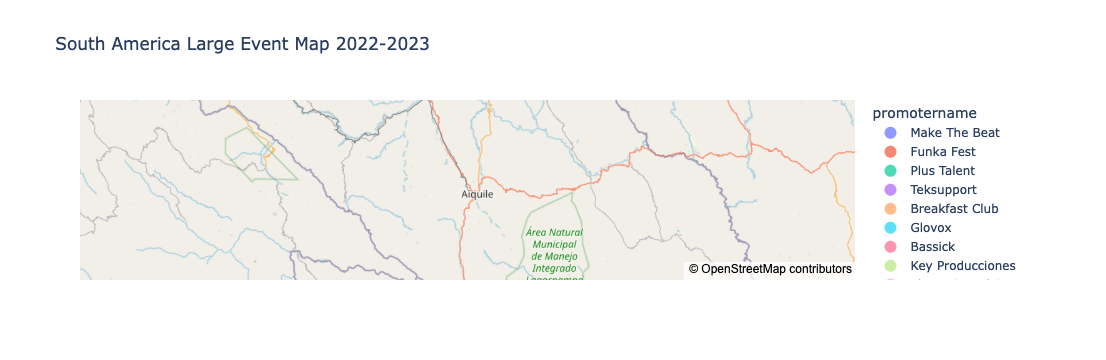

In [39]:
# Create an interactive map using Plotly Express
fig = px.scatter_mapbox(
    df_fifth,
    lat='latitude',
    lon='longitude',
    text='promotername',
    hover_data=['capacity', 'venuename'],
    color='promotername',
    size='capacity',
    size_max=25,
    mapbox_style='open-street-map',
    zoom=8,
    center=dict(lat=df_fifth['latitude'].mean(), lon=df_fifth['longitude'].mean()),
    title='South America Large Event Map 2022-2023'
)

# Show the interactive map
fig.show()